<a href="https://colab.research.google.com/github/farhadfarokhseresht/MRI-image-processing-python/blob/main/MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom
!pip install pypng
import pydicom as dicom
import matplotlib.pylab as plt
import glob
import cv2
import numpy as np
import pandas as pd
import re
import os
import png
from google.colab.patches import cv2_imshow
import math
from scipy import ndimage
from skimage.color import rgb2gray
from PIL import Image 
from skimage.color import rgb2gray
import skimage.segmentation as seg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#import  data

In [ ]:
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/IBMB Dataset.zip","r") as zipobj:
  zipobj.extractall()

In [ ]:
IBMB_df = pd.read_excel('/content/drive/MyDrive/IBMB Dataset.xlsx',index_col="Patient's Name")  

{"Patientname": [mri dir path] }

In [ ]:
#{"Patientname": [mri dir path] }
dir1 = os.listdir('/content/IBMB Dataset') # folder name list 
mri_data_dir = {}
for d1 in dir1:
  dirpath = "/content/IBMB Dataset/" + d1 
  dir2 = os.listdir(dirpath) # Patient's Name 
  Patientname = int(re.findall(r'\d+',dir2[0])[0])
  dir3 = os.listdir(dirpath + "/" + dir2[0]) # 1 folder in  Patient's Name Series 13-t2_tirm_tra_dark-fluid
  dirpath = dirpath + "/" + dir2[0]
  dir4 = os.listdir(dirpath + "/" + dir3[0]) # mri_data
  dirpath = dirpath + "/" + dir3[0]
  mri_dirs = []
  for imgname in dir4 :
    mri_dirs.append(dirpath+"/"+imgname)
  mri_data_dir[Patientname] = mri_dirs

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):
    xx=1
    yy=h/w
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt(    ((X - center[0])**2)/xx + ((Y-center[1])**2)/yy     )

    mask = dist_from_center <= radius
    return mask

convert to png 

In [ ]:
os.mkdir("/content/IBMBDATA")
IBMBDATA = {}
for pid in mri_data_dir.keys():
  os.mkdir("/content/IBMBDATA/"+str(pid))
  p_dir = []
  for dcm_dir in mri_data_dir[pid]:
    ds = dicom.dcmread(dcm_dir)
    sl_num = int(ds.InstanceNumber)
    if 11 <= sl_num <= 13 :
      shape = ds.pixel_array.shape
      # Convert to float to avoid overflow or underflow losses.
      image_2d = ds.pixel_array.astype(float)
      # Rescaling grey scale between 0-255
      image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
      # Convert to uint
      image_2d_scaled = np.uint8(image_2d_scaled)
      # Write the PNG file
      file_dir_name = "/content/IBMBDATA/"+str(pid)+"/"+str(sl_num)+".png"
      with open(file_dir_name,'wb') as png_file:
        w = png.Writer(shape[1], shape[0], greyscale=True)
        w.write(png_file, image_2d_scaled)
      p_dir.append(file_dir_name)
  IBMBDATA[pid] = p_dir

add hight and whight of brain to IBMB data frame 

In [ ]:
hi = []
wh = []
for indx in IBMB_df.index :
  h=[]
  w = []
  for pic in IBMBDATA[indx]:
    image = cv2.imread(pic,0)
    blur  = cv2.GaussianBlur(image,(11,11),5)
    ret, thresh1 = cv2.threshold(blur ,100, 255, cv2.THRESH_BINARY) 
    loc = ndimage.find_objects(thresh1 == 255)[0]
    new = image[loc]
    h.append(new.shape[0])
    w.append(new.shape[1])
  hi.append(np.mean(h))
  wh.append(np.mean(w))

IBMB_df["hi"] = hi
IBMB_df["wh"] = wh

In [ ]:
for pid in IBMBDATA.keys() :
  for dcmim in IBMBDATA[pid] :
    image = cv2.imread(dcmim,0)
    blur  = cv2.GaussianBlur(image,(11,11),5)
    ret, thresh1 = cv2.threshold(blur ,100, 255, cv2.THRESH_BINARY) 
    loc = ndimage.find_objects(thresh1 == 255)[0]
    new = image[loc]
    h,w= new.shape
    mask = create_circular_mask(h,w)*new
    cv2.imwrite(dcmim,mask)

functions for extract information from images


In [ ]:
def neighbors(a,radius, rowNumber, columnNumber):
     return [[a[i][j] if  i >= 0 and i < len(a) and j >= 0 and j < len(a[0]) else 0
                for j in range(columnNumber-1-radius, columnNumber+radius)]
                    for i in range(rowNumber-1-radius, rowNumber+radius)]

def neighbors_dep(image2,dep):
  locpix = np.where(image2>0)
  pixCon = {}
  dep = dep
  for c in range(len(locpix[0])):
    locpix_ij = [locpix[0][c],locpix[1][c]]
    neb = neighbors(image2,dep,locpix_ij[0],locpix_ij[1])
    cont = 0
    for ni in neb:
      for nj in ni:
        if nj > 0 :
          cont = cont+1
    pixCon[(locpix_ij[0],locpix_ij[1])] = cont
  zimg = np.zeros((image2.shape[0],image2.shape[1]))
  for c in range(len(locpix[0])):
    locpix_ij = [locpix[0][c],locpix[1][c]]
    zimg[locpix[0][c],locpix[1][c]] = pixCon[(locpix_ij[0],locpix_ij[1])] 
  out = len(np.where(zimg==np.max(zimg))[0])
  #plt.imshow(zimg, cmap='gray')
  return({"out":out}) #,"zimg":zimg

In [ ]:
from skimage.color import rgb2gray
def info (dir):
  image = cv2.imread(dir)
  blur  = cv2.GaussianBlur(image,(11,11),5)
  ret, thresh1 = cv2.threshold(blur ,75, 255, cv2.THRESH_BINARY) 
  gray = rgb2gray(thresh1)
  image = rgb2gray(image)
  gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
  image = image.reshape(image.shape[0]*image.shape[1])
  for i in range(gray_r.shape[0]):
    if gray_r[i] != 0  :
      image[i] = image[i]
    else:
      image[i] = np.nan    
  image = image.reshape(gray.shape[0],gray.shape[1])
  gray = rgb2gray(image)
  gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
  Q1 = np.nanquantile(gray_r,.25)
  Q3 = np.nanquantile(gray_r,.90)
  lower = Q1*1.5
  upper = Q3*1.5
  #con = 0
  for i in range(gray_r.shape[0]):
    if (gray_r[i] <= lower) | (gray_r[i] >= upper)  :  #(gray_r[i] <=l) | (gray_r[i] >= u)
      gray_r[i] = np.nan
    else:
      #con = con +1
      gray_r[i] = gray_r[i]
  con   = sum(gray_r>0)
  image2 = gray_r.reshape(gray.shape[0],gray.shape[1])
  trakom = neighbors_dep(image2,1)["out"]
  #zimg = neighbors_dep(image2,1)["zimg"]
  #zimg = zimg.reshape(zimg.shape[0]*zimg.shape[1])
  mean_p = np.nanmean(image2)
  dim = image2.shape
  h,w = dim
  y = 0 
  x = int(round(w/2,0))
  crop_img1 = image2[y:y+h,0:x]
  crop_img2 = image2[y:y+h,x:x+w]
  crop_img1 = crop_img1.reshape(crop_img1.shape[0]*crop_img1.shape[1])
  crop_img2 = crop_img2.reshape(crop_img2.shape[0]*crop_img2.shape[1])
  left_right = sum(crop_img1>0)-sum(crop_img2>0)
  y = int(round(h/2,0))
  x = 0 
  crop_imgDOWN = image2[y:y+h,0:x+w]
  crop_imgUP = image2[0:y,0:x+w]
  crop_imgDOWN = crop_imgDOWN.reshape(crop_imgDOWN.shape[0]*crop_imgDOWN.shape[1])
  crop_imgUP = crop_imgUP.reshape(crop_imgUP.shape[0]*crop_imgUP.shape[1])
  up_down = sum(crop_imgUP>0)-sum(crop_imgDOWN>0)
  lis = [con,mean_p,left_right,up_down,trakom]
  return({"lis":lis}) #,"zimg":zimg

In [ ]:
info(IBMBDATA[980503871101][1])

{'lis': [546, 0.742713495654672, 282, 292, 10]}

In [ ]:
IBMB_df[IBMB_df['PVWM']==0]

# pross

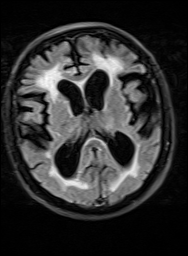

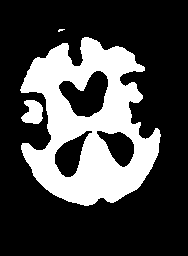

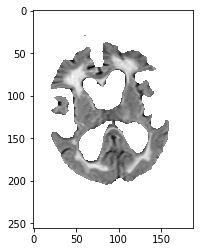

In [ ]:
imdr = IBMBDATA[980502731101][1]#980502731101
image = cv2.imread(imdr)
cv2_imshow(image)
blur  = cv2.GaussianBlur(image,(11,11),5)
ret, thresh1 = cv2.threshold(blur ,75, 255, cv2.THRESH_BINARY) 
cv2_imshow(thresh1)
gray = rgb2gray(thresh1)
image = rgb2gray(image)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
image = image.reshape(image.shape[0]*image.shape[1])
for i in range(gray_r.shape[0]):
  if gray_r[i] != 0  :
    image[i] = image[i]
  else:
    image[i] = np.NaN
image = image.reshape(gray.shape[0],gray.shape[1])
plt.imshow(image, cmap='gray')


1853
0.7854755933674064


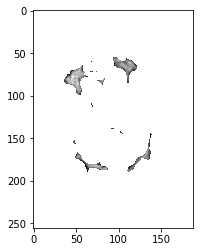

In [ ]:
gray = image.copy() #rgb2gray()
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
con = 0
Q1 = np.nanquantile(gray_r,.25)
Q3 = np.nanquantile(gray_r,.90)
lower = Q1*1.5
upper = Q3*1.5
for i in range(gray_r.shape[0]):
  if (gray_r[i] < lower) or (gray_r[i] > upper)  :  #(gray_r[i] <=l) | (gray_r[i] >= u)
    gray_r[i] =  np.NaN # gray_r[i]
  else:
    gray_r[i] = gray_r[i]
con   = sum(gray_r>0)
print(con)
print(np.nanmean(gray_r))
image2 = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(image2, cmap='gray')


In [ ]:
a = np.array([[0,5,0,0,0],
              [0,0,2,0,0],
              [0,0,0,0,0],
              [0,0,0,0,0],
              ])
neighbors(a,2,1,1)

In [ ]:
def neighbors(a,radius, rowNumber, columnNumber):
     return [[a[i][j] if  i >= 0 and i < len(a) and j >= 0 and j < len(a[0]) else 0
                for j in range(columnNumber-1-radius, columnNumber+radius)]
                    for i in range(rowNumber-1-radius, rowNumber+radius)]

def neighbors_dep(image2,dep):
  locpix = np.where(image2>0)
  pixCon = {}
  dep = dep
  for c in range(len(locpix[0])):
    locpix_ij = [locpix[0][c],locpix[1][c]]
    neb = neighbors(image2,dep,locpix_ij[0],locpix_ij[1])
    cont = 0
    for ni in neb:
      for nj in ni:
        if nj > 0 :
          cont = cont+1
    pixCon[(locpix_ij[0],locpix_ij[1])] = cont
  zimg = np.zeros((image2.shape[0],image2.shape[1]))
  for c in range(len(locpix[0])):
    locpix_ij = [locpix[0][c],locpix[1][c]]
    zimg[locpix[0][c],locpix[1][c]] = pixCon[(locpix_ij[0],locpix_ij[1])] 
  out = len(np.where(zimg==np.max(zimg))[0])
  plt.imshow(zimg, cmap='gray')
  return({"out":out,"zimg":zimg})

1021

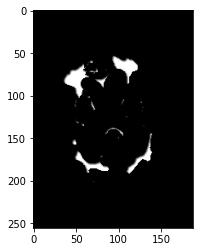

In [ ]:
neighbors_dep(image2,1)["out"]

#update data set

In [ ]:
#con,mean_p,left_right,up_down
wm_pix_count1 = []
wm_pix_count2 = []
wm_pix_count3 = []
num_pix_incon1 = []
num_pix_incon2 = []
num_pix_incon3 = []
up_down = []
left_right = []
#mean_p = []
dep_df = {}
for indx in IBMB_df.index :
  u_d = []
  l_r = []
  #m_p = []
  #countl1 = []
  #countl2 = []
  #countl3 = []
  for pic in IBMBDATA[indx]:
    print(pic)
    #m_p.append(info(pic)["lis"][1])
    l_r.append(info(pic)["lis"][2])
    u_d.append(info(pic)["lis"][3])
  wm_pix_count1.append(info(IBMBDATA[indx][0])["lis"][0])
  wm_pix_count2.append(info(IBMBDATA[indx][1])["lis"][0])
  wm_pix_count3.append(info(IBMBDATA[indx][2])["lis"][0])
  num_pix_incon1.append(info(IBMBDATA[indx][0])["lis"][4])
  num_pix_incon2.append(info(IBMBDATA[indx][1])["lis"][4])
  num_pix_incon3.append(info(IBMBDATA[indx][2])["lis"][4])
  #mean_p.append(np.mean(m_p))
  up_down.append(np.mean(u_d))
  left_right.append(np.mean(l_r))
  #dep_df[indx] = info(IBMBDATA[indx][1])["zimg"]

IBMB_df["wm_pix_count1"] = wm_pix_count1
IBMB_df["wm_pix_count2"] = wm_pix_count2
IBMB_df["wm_pix_count3"] = wm_pix_count3
#IBMB_df["mean_p"] = mean_p
IBMB_df["up_down"] = up_down
IBMB_df["left_right"] = left_right
IBMB_df["num_pix_incon1"] = num_pix_incon1
IBMB_df["num_pix_incon2"] = num_pix_incon2
IBMB_df["num_pix_incon3"] = num_pix_incon3

In [ ]:
IBMB_df.describe()

In [ ]:
df = IBMB_df.copy()

###catgori

In [ ]:

Q1 = np.nanquantile(df['mean_p'],.25)
Q3 = np.nanquantile(df['mean_p'],.75)
lower = Q1*1.5
upper = Q3*1.5
mean = np.mean(df['mean_p'])
for idx in df.index:
  x = df['mean_p'][df.index == idx]
  x = list(x)[0]
  if x < lower :
    df['mean_p'][df.index== idx] =  0
  elif lower <= x <= mean :
    df['mean_p'][df.index== idx] =  1
  elif mean < x <= upper :
    df['mean_p'][df.index== idx] =  2
  elif  x >  upper :
    df['mean_p'][df.index== idx] =  4

In [ ]:
Q1 = np.nanquantile(df['up_down'],.25)
Q3 = np.nanquantile(df['up_down'],.75)
lower = Q1*1.5
upper = Q3*1.5
mean = np.mean(df['up_down'])
for idx in df.index:
  x = df['up_down'][df.index == idx]
  x = list(x)[0]
  if x < lower :
    df['up_down'][df.index== idx] =  0
  elif lower <= x <= mean :
    df['up_down'][df.index== idx] =  1
  elif mean < x <= upper :
    df['up_down'][df.index== idx] =  2
  elif  x >  upper :
    df['up_down'][df.index== idx] =  4

In [ ]:

Q1 = np.nanquantile(df['left_right'],.25)
Q3 = np.nanquantile(df['left_right'],.75)
lower = Q1*1.5
upper = Q3*1.5
mean = np.mean(df['left_right'])
for idx in df.index:
  x = df['left_right'][df.index == idx]
  x = list(x)[0]
  if x < lower :
    df['left_right'][df.index== idx] =  0
  elif lower <= x <= mean :
    df['left_right'][df.index== idx] =  1
  elif mean < x <= upper :
    df['left_right'][df.index== idx] =  2
  elif  x >  upper :
    df['left_right'][df.index== idx] =  4

In [ ]:
Q1 = np.nanquantile(df['countl1'],.25)
Q3 = np.nanquantile(df['countl1'],.75)
lower = Q1*1.5
upper = Q3*1.5
mean = np.mean(df['countl1'])
for idx in df.index:
  x = df['countl1'][df.index == idx]
  x = list(x)[0]
  if x < lower :
    df['countl1'][df.index== idx] =  0
  elif lower <= x <= mean :
    df['countl1'][df.index== idx] =  1
  elif mean < x <= upper :
    df['countl1'][df.index== idx] =  2
  elif  x >  upper :
    df['countl1'][df.index== idx] =  4

In [ ]:
Q1 = np.nanquantile(df['countl2'],.25)
Q3 = np.nanquantile(df['countl2'],.75)
lower = Q1*1.5
upper = Q3*1.5
mean = np.mean(df['countl2'])
for idx in df.index:
  x = df['countl2'][df.index == idx]
  x = list(x)[0]
  if x < lower :
    df['countl2'][df.index== idx] =  0
  elif lower <= x <= mean :
    df['countl2'][df.index== idx] =  1
  elif mean < x <= upper :
    df['countl2'][df.index== idx] =  2
  elif  x >  upper :
    df['countl2'][df.index== idx] =  4

In [ ]:
Q1 = np.nanquantile(df['countl3'],.25)
Q3 = np.nanquantile(df['countl3'],.75)
lower = Q1*1.5
upper = Q3*1.5
mean = np.mean(df['countl3'])
for idx in df.index:
  x = df['countl3'][df.index == idx]
  x = list(x)[0]
  if x < lower :
    df['countl3'][df.index== idx] =  0
  elif lower <= x <= mean :
    df['countl3'][df.index== idx] =  1
  elif mean < x <= upper :
    df['countl3'][df.index== idx] =  2
  elif  x >  upper :
    df['countl3'][df.index== idx] =  4

In [ ]:
df

##info

In [ ]:

for x in df.index:
  path = mri_data_dir[x][0]
  ds = dicom.dcmread(path)
  sl_num = int(ds.InstanceNumber)
  page = ds.PatientAge.lower()
  page = int(re.sub(r'[a-z]+', '', page, re.I) )
  psex = ds.PatientSex
  pweight = int(ds.PatientWeight)
  df["Patient's Age"][df.index==x] = page
  df["Patient's Weight"][df.index==x] = pweight
  df["Patient's Sex"][df.index==x] = psex



In [ ]:
df = df.fillna(method="ffill")

In [ ]:
df.to_excel("data.xlsx")  

# Data Visualization Analysis


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
columns = df.keys()
columns = list(columns)

In [ ]:
df0 = df[df['PVWM']==0]
df1 = df[df['PVWM']==1]
df2 = df[df['PVWM']==2]
df3 = df[df['PVWM']==3]

In [ ]:
df0.describe()

In [ ]:
df1.describe()

In [ ]:
df2.describe()

In [ ]:
df3.describe()

In [ ]:
df.describe()

In [ ]:
corr = df.corr()
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(corr, annot=True , fmt=".2" ,linewidths=.1)

In [ ]:
pd.pivot_table(df, index='PVWM', columns="Patient's Sex", aggfunc=np.mean)

In [ ]:
df.groupby(['PVWM']).agg({'left_right' : np.mean, 'up_down': np.mean  }).plot(kind='bar', figsize=(20,10), title='means ' ,cmap = 'cividis')


In [ ]:
# Draw Stripplot
sns.stripplot(df['PVWM'],df['countl2'])

# Decorations
plt.title('chest pain vs blood pressure', fontsize=15)
plt.show()

In [ ]:
#print (df.groupby(["Patient's Sex", 'PVWM']).size().unstack())
df.groupby(["Patient's Sex", 'PVWM']).size().unstack().plot(kind='bar', figsize=(20,10), title='Patients Sex_PVWM histogram' ,cmap = 'cividis')

In [ ]:
df.groupby(["sliseid", 'PVWM']).size().unstack().plot(kind='bar', figsize=(20,10), title='Patients Sex_PVWM histogram' ,cmap = 'cividis')

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x="mean_p", y="up_down", size="countl2",
                palette="ch:r=-.2 , d=.3",
                hue="PVWM",
                sizes=(200,100), linewidth=1,edgecolor='k',data=df)


In [ ]:
ax = sns.boxplot(x="Patient's Sex", y="up_down", data=df)
ax = sns.swarmplot(x="Patient's Sex", y="up_down", data=df, color=".2")

In [ ]:
plt.figure(figsize=(100,0), dpi= 150)
sns.pairplot(df,vars = [ "Patient's Age" , "Patient's Weight", "left_mean"],  kind="reg", hue="PVWM")
plt.show()

In [ ]:
sns.pairplot(df,
             vars = [ "right_mean" , "Patient's Weight", "left_mean"],
             kind="scatter", hue="Patient's Sex",
             plot_kws=dict(s=80, edgecolor="blue", linewidth=.75))

In [ ]:
sns.jointplot(x=df["Patient's Weight"], y=df['mean_p'], kind='hex')

#model

In [ ]:
df = pd.read_excel ("/content/data.xlsx")

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
x = df["Patient's Sex"]
df["Patient's Sex"] = label_encoder.fit_transform(x)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df

In [ ]:
columns = df.keys()
columns = list(columns)

y = df["Patient's Sex"]
x = df[columns[1:]]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)  # Don't cheat - fit only on training data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)  # apply same transformation to test data

tree

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()  # tree.DecisionTreeRegressor() tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
y_pred = clf.fit(x_train,y_train).predict(x_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred )

0.6666666666666666

GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train,y_train).predict(x_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred )

0.717948717948718

neighbors

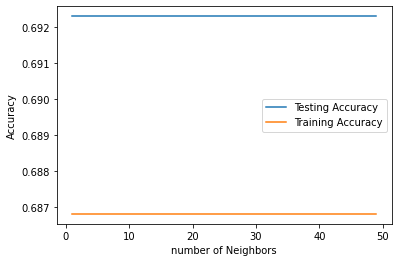

In [ ]:
#weights = 'distance'  algorithm = 'kd_tree'  algorithm = 'brute' or 'ball_tree'
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
neighbors = np.arange(1,50)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
for i,k in enumerate(neighbors):
  knn_model =  NearestCentroid() #KNeighborsClassifier(n_neighbors=k,p=2, algorithm = 'ball_tree')
  knn_model.fit(x_train, y_train)
  train_accuracy[i] = knn_model.score(x_train, y_train)
  test_accuracy[i] = knn_model.score(x_test, y_test)
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(x_train, y_train)
print(nca_pipe.score(x_test, y_test))

0.6666666666666666


In [ ]:
X, Y = x_train , y_train
x = x_test

Neural network models 

In [ ]:
from sklearn.neural_network import MLPClassifier
neighbors = np.arange(1,30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
for i,k in enumerate(neighbors):
  clf =  MLPClassifier(solver='lbfgs',alpha=1e-5, hidden_layer_sizes=(k,2), random_state=1,max_iter=1, warm_start=True)
  clf = clf.fit(x_train, y_train)
  train_accuracy[i] = clf.score(x_train, y_train)
  test_accuracy[i] = clf.score(x_test, y_test)
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

svm

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC())
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred )

0.7307692307692307

In [ ]:
from sklearn import svm
clf = svm.SVC() # decision_function_shape='ovo' , 
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred )

0.7307692307692307

In [ ]:
from sklearn import svm
clf = svm.LinearSVC() 
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred )

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6923076923076923

In [ ]:
#sex
from sklearn import svm
clf = svm.SVR( kernel='precomputed') #kernel='rbf'  kernel='precomputed' kernel='linear'
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred )

In [ ]:
X = x_train
Y = y_train

In [ ]:
def my_kernel(X, Y):
  return np.dot(X, Y.T)

from sklearn import svm
clf = svm.LinearSVC() 
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred )



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6923076923076923

In [ ]:

from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="modified_huber", penalty="l2", max_iter=5)#modified_huber  hinge log
clf.fit(X, Y)                                 # l2  l1 elasticnet
y_pred = clf.predict(x_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred )



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.6794871794871795

# tsts

In [ ]:
frames  = []
for ky in dep_df.keys():
  f = pd.DataFrame(dep_df[ky]).T
  frames.append(f)